# Capacitated Location Set Covering Problem–System Optimal (CLSCP-SO)

*Authors:* [Erin Olson](https://github.com/erinrolson), [Germano Barcelos](https://github.com/gegen07), [James Gaboardi](https://github.com/jGaboardi), [Levi J. Wolf](https://github.com/ljwolf), [Qunshan Zhao](https://github.com/qszhao)

The Capacitated Location Set Covering – System Optimal (CLSCP-SO) model builds off of the [LSCP](https://pysal.org/spopt/notebooks/lscp.html), but allows for the assignment of a facility's capacity and the amount of demand at a demand point to be used in the siting of facilities. CLSCP-SO can be described as follows:

"_Locate just enough facilities and associated capacity such that all demand is served within the capacity limits of each facility, given the coverage capabilities of each facility._" Church L. & Murray, A. (2018)

**CLSCP-SO can be written as:**

$\begin{array}
\displaystyle \textbf{Minimize}    & \displaystyle \sum_{j \in J}{Y_j} && (1) \\
\displaystyle \textbf{Subject to:} & \displaystyle \sum_{j \in N_i}{z_{ij}} = 1 & \forall i \in I & (2) \\
                                   & \displaystyle \sum_{i \in I} a_i z_{ij} \leq C_jx_j & \forall j \in J & (3) \\
                                   & Y_j \in {0,1} & \forall j \in J & (4) \\
                                   & z_{ij} \geq 0 & \forall i \in I \quad \forall j \in N_i & (5) \\
\end{array}$

$\begin{array}
\displaystyle \textbf{Where:}\\ & & \displaystyle i & \small = & \textrm{index of demand points/areas/objects in set } I \\
& & j & \small = & \textrm{index of potential facility sites in set } J \\
& & S & \small = & \textrm{maximal acceptable service distance or time standard} \\
& & d_{ij} & \small = & \textrm{shortest distance or travel time between nodes } i \textrm{ and } j \\
& & N_i & \small = & \{j | d_{ij} < S\} \\
& & a_i & \small = & \textrm{amount of demand at } i \\
& & C_j & \small = & \textrm{capacity of potential facility } j \\
& & z_{ij} & \small = & \textrm{fraction of demand } i \textrm{ that is assigned to facility } j \\
& & Y_j & \small = & \begin{cases} 
          1, \text{if a facility is located at node } j\\
          0, \text{otherwise} \\
       \end{cases}
\end{array}$

_The formulation above is adapted from Church and Murray (2018)._

--------------------

This tutorial solves the CLSCP-SO by generating synthetic demand (clients) and facility sites near a 10x10 lattice representing a gridded urban core, and is broken out as follows:

1. Data and setup
2. Demonstrating the CLSCP-SO with 2 facilities and 5 five client sites
  * Six scenarios are detailed in which facility capacity is swapped between sites
2. Comparing solutions to covering problems with a single pre-defined facility
  * CLSCP-SO
  * standard LSCP

In [1]:
%config InlineBackend.figure_format = "retina"
%load_ext watermark
%watermark

Last updated: 2023-01-01T21:37:58.065750-05:00

Python implementation: CPython
Python version       : 3.10.8
IPython version      : 8.7.0

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 22.2.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [2]:
import geopandas
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.lines as mlines
import numpy
import pandas
import pulp
import shapely
import spopt
from spopt.locate import LSCP, LSCPB, MCLP, simulated_geo_points

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # ignore deprecation warning - GH pysal/spaghetti#649
    import spaghetti

%watermark -w
%watermark -iv

Watermark: 2.3.1

pulp      : 2.7.0
pandas    : 1.5.2
geopandas : 0.12.2
numpy     : 1.23.5
json      : 2.0.9
matplotlib: 3.6.2
shapely   : 2.0.0
spopt     : 0.4.1+200.g336f235.dirty
spaghetti : 1.6.10



----------------------

## 1. Data and setup

Since the model needs a distance cost matrix we should define some variables. In the comments, it's defined what these variables are for but solver. The solver, assigned below as `pulp.PULP_CBC_CMD`, is an interface to optimization solver developed by [COIN-OR](https://github.com/coin-or/Cbc). If you want to use another optimization interface as Gurobi or CPLEX see this [guide](https://coin-or.github.io/pulp/guides/how_to_configure_solvers.html) that explains how to achieve this.

In [3]:
# quantity demand points
CLIENT_COUNT = 5

# quantity supply points
FACILITY_COUNT = 2

# maximum service radius (in distance units)
SERVICE_RADIUS = 15

# random seeds for reproducibility
CLIENT_SEED = 5
FACILITY_SEED = 6

# set the solver
solver = pulp.COIN_CMD(msg=False, warmStart=True)

### Lattice 10x10

Create a 10x10 lattice with 9 interior lines, both vertical and horizontal.

In [4]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # ignore deprecation warning - GH pysal/libpysal#468
    lattice = spaghetti.regular_lattice((0, 0, 10, 10), 9, exterior=True)
ntw = spaghetti.Network(in_data=lattice)

Transform the `spaghetti` instance into a geodataframe.

In [5]:
streets = spaghetti.element_as_gdf(ntw, arcs=True)

In [6]:
streets_buffered = geopandas.GeoDataFrame(
    geopandas.GeoSeries(streets["geometry"].buffer(0.2).unary_union),
    crs=streets.crs,
    columns=["geometry"],
)

Plotting the network created by `spaghetti` we can verify that it mimics a district with quarters and streets.

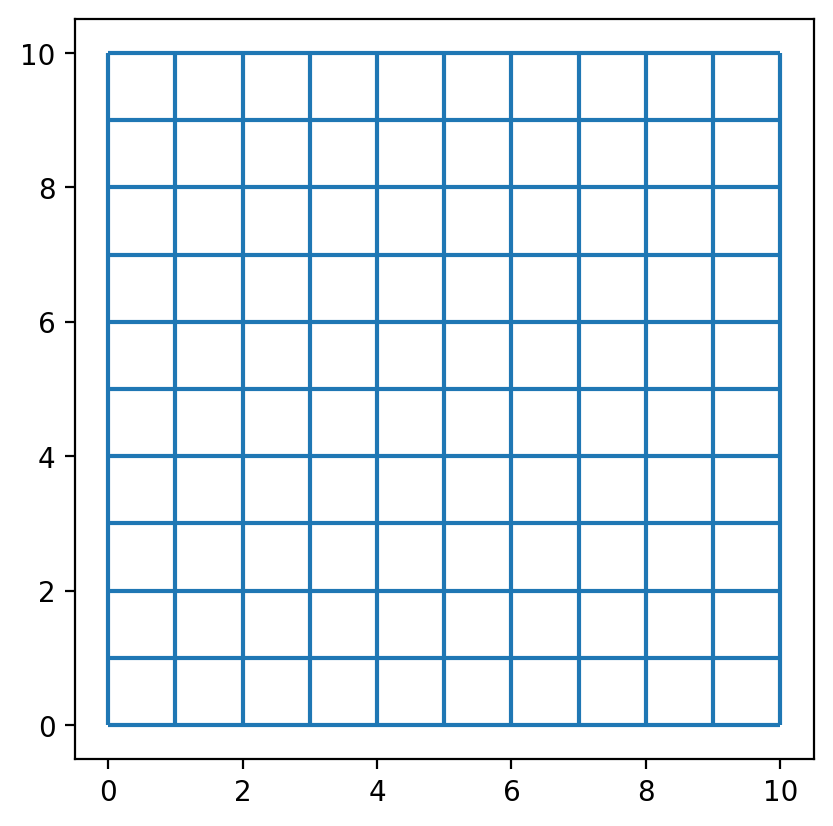

In [7]:
streets.plot();

### Simulate points in a network

The `simulated_geo_points` function simulates points near a network. In this case, it uses the 10x10 lattice network created using the `spaghetti` package. Below we use the function defined above and simulate the points near the lattice edges.

In [8]:
client_points = simulated_geo_points(
    streets_buffered, needed=CLIENT_COUNT, seed=CLIENT_SEED
)
facility_points = simulated_geo_points(
    streets_buffered, needed=FACILITY_COUNT, seed=FACILITY_SEED
)

Plotting the 5 client and 2 facility points we can see that the function generates dummy points to an area of 10x10, which is the area created by our lattice created on previous cells.

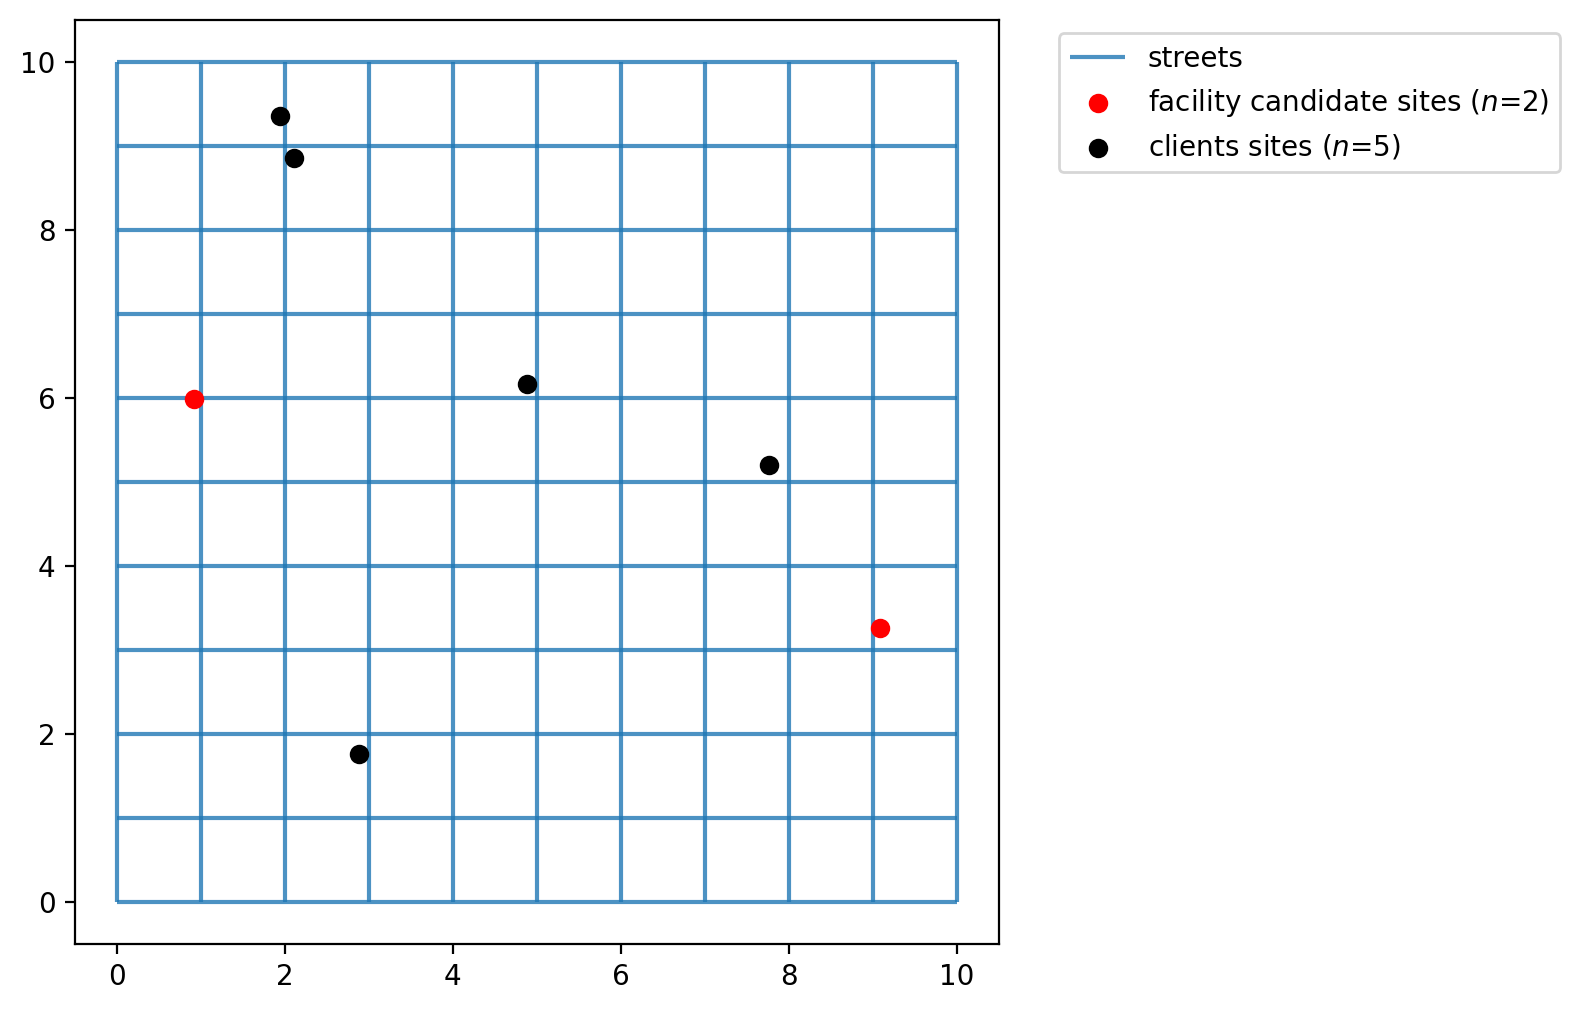

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))
streets.plot(ax=ax, alpha=0.8, zorder=1, label="streets")
facility_points.plot(
    ax=ax, color="red", zorder=2, label=f"facility candidate sites ($n$={FACILITY_COUNT})"
)
client_points.plot(ax=ax, color="black", label=f"clients sites ($n$={CLIENT_COUNT})")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1));

### Assign simulated points network locations

The simulated client and facility points do not ahere to network space. Calculating distances between them without restricting movement to the network results in a euclidean distances,'as the crow flies.' While this is acceptable for some applications, for others it is more realistic to consider network traversal (e.g. Does a mail carrier follow roads to deliver letters or fly from mailbox to mailbox?).

In our first example we will consider distance along the 10x10 lattice network created above. Therefore, we must first snap the observation points to the network prior to calculating a cost matrix.

In [10]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # ignore deprecation warning - GH pysal/libpysal#468
    ntw.snapobservations(client_points, "clients", attribute=True)
clients_snapped = spaghetti.element_as_gdf(ntw, pp_name="clients", snapped=True)
clients_snapped.drop(columns=["id", "comp_label"], inplace=True)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # ignore deprecation warning - GH pysal/libpysal#468
    ntw.snapobservations(facility_points, "facilities", attribute=True)
facilities_snapped = spaghetti.element_as_gdf(ntw, pp_name="facilities", snapped=True)
facilities_snapped.drop(columns=["id", "comp_label"], inplace=True)

Now the plot seems more organized as the points occupy network space. The network is plotted below with the network locations of the facility points and clients points.

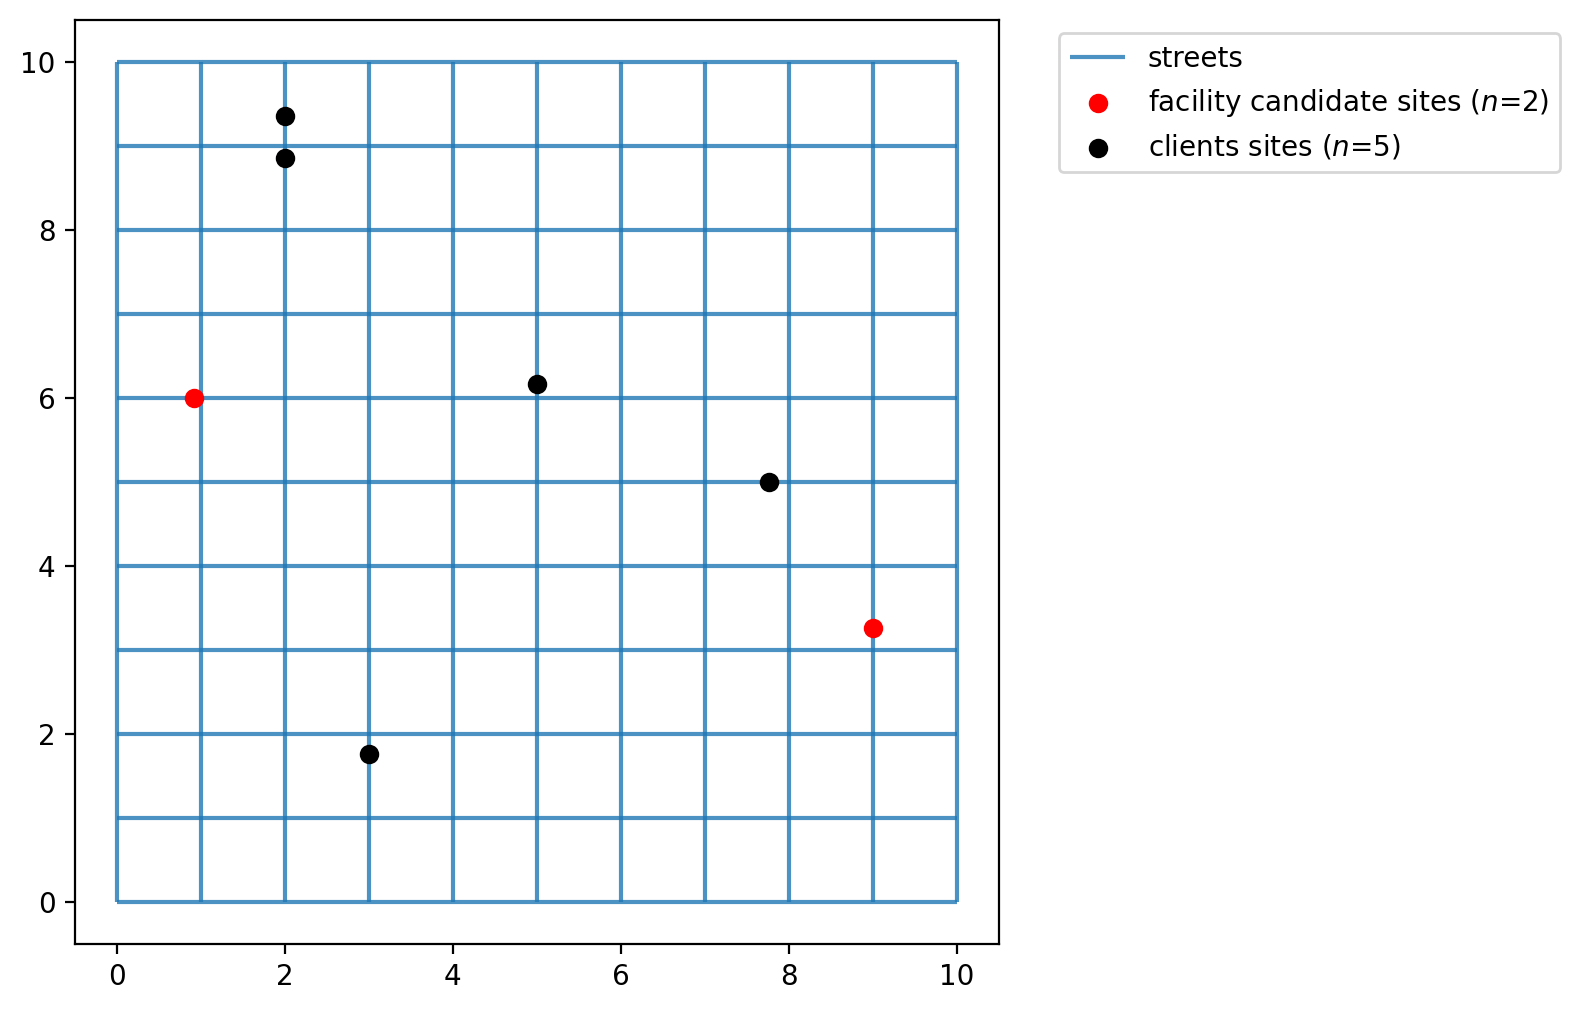

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))
streets.plot(ax=ax, alpha=0.8, zorder=1, label="streets")
facilities_snapped.plot(
    ax=ax, color="red", zorder=2, label=f"facility candidate sites ($n$={FACILITY_COUNT})"
)
clients_snapped.plot(ax=ax, color="black", label=f"clients sites ($n$={CLIENT_COUNT})")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1));

### Calculating the (network distance) cost matrix
Calculate the network distance between clients and facilities.

In [12]:
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["clients"],
    destpattern=ntw.pointpatterns["facilities"],
)
cost_matrix.shape

(5, 2)

The expected result here is a network distance between clients and facilities points, in our case a 2D 5x2 array.

In [13]:
cost_matrix

array([[12.60302601,  3.93598651],
       [13.10096347,  4.43392397],
       [ 6.9095462 ,  4.2425067 ],
       [ 2.98196832,  7.84581224],
       [ 7.5002892 ,  6.32806975]])

----------------------

## 2. Demonstrating CLSCP-SO behavior

### Generating synthetic client demand and facility capacity

First create synthetic demand total 15 units.

In [14]:
client_points["demand"] = numpy.arange(1, 6)
client_points

,geometry,demand
0,POINT (2.10873 8.85562),1
1,POINT (1.94988 9.35355),2
2,POINT (4.87948 6.16214),3
3,POINT (7.76544 5.19155),4
4,POINT (2.88673 1.75230),5


By manipulating client demand and facility capacity we can demonstrate how capacity is accounted for and generates different results. We'll do this using 6 different scenarios while adjusting the capacities at the two sites.

1. $1 \gg 2 \quad [15, 5]$: Facility 1 has much more capacity than Facility 2. Only Facility 1 provides a feasible solution.
2. $1 \ll 2 \quad [5, 15]$: Facility 1 has much less capacity than Facility 2. Only Facility 2 provides a feasible solution.
3. $1 \gtrapprox 2 \quad [8, 7]$: Facility 1 and Facility 2 have nearly equal capacity, but Facility 1 is slightly larger. Neither facility can serve all demand alone.
4. $1 \equiv 2 \quad [15, 15]$: Facility 1 and Facility 2 have equivalent capacity. Either facility can serve all demand.
5. $1 \gtrapprox 2 \quad [16, 15]$: Facility 1 and Facility 2 have nearly equal capacity, but Facility 1 is slightly larger. Either facility can serve all demand.
6. $1 \lessapprox 2 \quad [15, 16]$: Facility 1 and Facility 2 have nearly equal capacity, but Facility 2 is slightly larger. Either facility can serve all demand.

Since the sum of demand quantity is 15, the problem will be feasible in all cases. We know this because the capacity of the system must always be greater than the demand. 

In [15]:
facility_points["cap_1"] = [15, 5]
facility_points["cap_2"] = [5, 15]
facility_points["cap_3"] = [8, 7]
facility_points["cap_4"] = [15, 15]
facility_points["cap_5"] = [16, 15]
facility_points["cap_6"] = [15, 16]
facility_points

,geometry,cap_1,cap_2,cap_3,cap_4,cap_5,cap_6
0,POINT (9.08575 3.25259),15,5,8,15,16,15
1,POINT (0.91963 5.98854),5,15,7,15,15,16


With ``LSCP.from_cost_matrix`` we model the CLSCP-SO to cover all demand points within `SERVICE_RADIUS` distance units using the network distance cost matrix calculated above.

### Scenario 1
* facility 1 capacity >> facility 2 capacity
* only Facility 1 provides a feasible solution

In [16]:
clscpso_1 = LSCP.from_cost_matrix(
    cost_matrix,
    SERVICE_RADIUS,
    demand_quantity_arr=client_points["demand"],
    facility_capacity_arr=facility_points["cap_1"],
    name="CLSCP-SO_$1\gg2$"
)

The expected result is a solved instance of `LSCP`.

In [17]:
clscpso_1 = clscpso_1.solve(solver)
clscpso_1

Define the decision variable names used for mapping later.

In [18]:
facility_points["dv"] = clscpso_1.fac_vars
facility_points["dv"] = facility_points["dv"].map(lambda x: x.name.replace("_", ""))
facility_points

,geometry,cap_1,cap_2,cap_3,cap_4,cap_5,cap_6,dv
0,POINT (9.08575 3.25259),15,5,8,15,16,15,y0
1,POINT (0.91963 5.98854),5,15,7,15,15,16,y1


### Scenario 2
* facility 1 capacity << facility 2 capacity
* only Facility 2 provides a feasible solution

In [19]:
clscpso_2 = LSCP.from_cost_matrix(
    cost_matrix,
    SERVICE_RADIUS,
    demand_quantity_arr=client_points["demand"],
    facility_capacity_arr=facility_points["cap_2"],
    name="CLSCP-SO_$1\ll2$"
)
clscpso_2 = clscpso_2.solve(solver)

### Scenario 3
* facility 1 capacity $\gtrapprox$ facility 2 capacity
* neither facility can serve all demand alone

In [20]:
clscpso_3 = LSCP.from_cost_matrix(
    cost_matrix,
    SERVICE_RADIUS,
    demand_quantity_arr=client_points["demand"],
    facility_capacity_arr=facility_points["cap_3"],
    name="CLSCP-SO_$1\gtrapprox2$_low"
)
clscpso_3 = clscpso_3.solve(solver)

### Scenario 4
* facility 1 capacity $\equiv$ facility 2 capacity
* either facility can serve all demand

In [21]:
clscpso_4 = LSCP.from_cost_matrix(
    cost_matrix,
    SERVICE_RADIUS,
    demand_quantity_arr=client_points["demand"],
    facility_capacity_arr=facility_points["cap_4"],
    name="CLSCP-SO_$1\equiv2$_high"
)
clscpso_4 = clscpso_4.solve(solver)

### Scenario 5
* facility 1 capacity $\gtrapprox$ facility 2 capacity
* either facility can serve all demand

In [22]:
clscpso_5 = LSCP.from_cost_matrix(
    cost_matrix,
    SERVICE_RADIUS,
    demand_quantity_arr=client_points["demand"],
    facility_capacity_arr=facility_points["cap_5"],
    name="CLSCP-SO_$1\gtrapprox2$_high"
)
clscpso_5 = clscpso_5.solve(solver)

### Scenario 6
* facility 1 capacity $\lessapprox$ facility 2 capacity
* either facility can serve all demand

In [23]:
clscpso_6 = LSCP.from_cost_matrix(
    cost_matrix,
    SERVICE_RADIUS,
    demand_quantity_arr=client_points["demand"],
    facility_capacity_arr=facility_points["cap_6"],
    name="CLSCP-SO_$1\lessapprox2$_high"
)
clscpso_6 = clscpso_6.solve(solver)

### Plotting the results

The two cells below describe the plotting of the results. The plots display the facility sites that were selected with a star colored and the points covered with the same color. Demand points covered by more than one facility are displayed in overlapping concentric circles.

In [24]:
dv_colors_arr = [
    "darkcyan",
    "mediumseagreen",
    "saddlebrown",
    "darkslategray",
    "lightskyblue",
    "thistle",
    "lavender",
    "darkgoldenrod",
    "peachpuff",
    "coral",
    "mediumvioletred",
    "blueviolet",
    "fuchsia",
    "cyan",
    "limegreen",
    "mediumorchid",
]
dv_colors = {f"y{i}": dv_colors_arr[i] for i in range(len(dv_colors_arr))}
dv_colors

{'y0': 'darkcyan',
 'y1': 'mediumseagreen',
 'y2': 'saddlebrown',
 'y3': 'darkslategray',
 'y4': 'lightskyblue',
 'y5': 'thistle',
 'y6': 'lavender',
 'y7': 'darkgoldenrod',
 'y8': 'peachpuff',
 'y9': 'coral',
 'y10': 'mediumvioletred',
 'y11': 'blueviolet',
 'y12': 'fuchsia',
 'y13': 'cyan',
 'y14': 'limegreen',
 'y15': 'mediumorchid'}

In [25]:
def plot_results(model, p, facs, clis=None, ax=None):
    """Visualize optimal solution sets and context."""
    if not ax:
        multi_plot = False
        fig, ax = plt.subplots(figsize=(6, 6))
        markersize, markersize_factor = 4, 4
    else:
        ax.axis("off")
        multi_plot = True
        markersize, markersize_factor = 2, 2
    ax.set_title(model.name, fontsize=15)

    # extract facility-client relationships for plotting (except for p-dispersion)
    plot_clis = isinstance(clis, geopandas.GeoDataFrame)
    if plot_clis:
        cli_points = {}
    fac_sites = {}
    for i, dv in enumerate(model.fac_vars):
        if dv.varValue:
            dv, predef = facs.loc[i, ["dv", "predefined_loc"]]
            fac_sites[dv] = [i, predef]
            if plot_clis:
                geom = clis.iloc[model.fac2cli[i]]["geometry"]
                cli_points[dv] = geom
    
    # study area and legend entries initialization
    streets.plot(ax=ax, alpha=1, color="black", zorder=1)
    legend_elements = [mlines.Line2D([], [], color="black", label="streets")]
    
    if plot_clis:
        # any clients that not asscociated with a facility
        if model.name.startswith("MCLP"):
            c = "k"
            if model.n_cli_uncov:
                idx = [i for i, v in enumerate(model.cli2fac) if len(v) == 0]
                pnt_kws = dict(ax=ax, fc=c, ec=c, marker="s", markersize=7, zorder=2)
                clis.iloc[idx].plot(**pnt_kws)
            _label = f"Demand sites not covered ($n$={model.n_cli_uncov})"
            _mkws = dict(marker="s", markerfacecolor=c, markeredgecolor=c, linewidth=0)
            legend_elements.append(mlines.Line2D([], [], ms=3, label=_label, **_mkws))

    # all candidate facilities
    facs.plot(ax=ax, fc="brown", marker="*", markersize=80, zorder=8)
    _label = f"Facility sites ($n$={len(model.fac_vars)})"
    _mkws = dict(marker="*", markerfacecolor="brown", markeredgecolor="brown")
    legend_elements.append(mlines.Line2D([], [], ms=7, lw=0, label=_label, **_mkws))
    
    # facility-(client) symbology and legend entries
    zorder = 4
    for fname, (fac, predef) in fac_sites.items():
        cset = dv_colors[fname]
        if plot_clis:
            # clients
            geoms = cli_points[fname]
            gdf = geopandas.GeoDataFrame(geoms)
            gdf.plot(ax=ax, zorder=zorder, ec="k", fc=cset, markersize=100 * markersize)
            _label = f"Demand sites covered by {fname}"
            _mkws = dict(markerfacecolor=cset, markeredgecolor="k", ms=markersize + 7)
            legend_elements.append(
                mlines.Line2D([], [], marker="o", lw=0, label=_label, **_mkws)
            )
        # facilities
        ec = "k"
        lw = 2
        predef_label = "predefined"
        if model.name.endswith(predef_label) and predef:
            ec = "r"
            lw = 3
            fname += f" ({predef_label})"
        facs.iloc[[fac]].plot(
            ax=ax, marker="*", markersize=1000, zorder=9, fc=cset, ec=ec, lw=lw
        )
        _mkws = dict(markerfacecolor=cset, markeredgecolor=ec, markeredgewidth=lw)
        legend_elements.append(
            mlines.Line2D([], [], marker="*", ms=20, lw=0, label=fname, **_mkws)
        )
        # increment zorder up and markersize down for stacked client symbology
        zorder += 1
        if plot_clis:
            markersize -= markersize_factor / p
    
    if not multi_plot:
        # legend
        kws = dict(loc="upper left", bbox_to_anchor=(1.05, 0.7))
        plt.legend(handles=legend_elements, **kws)

### Scenario 1

In [26]:
facility_points["predefined_loc"] = 0

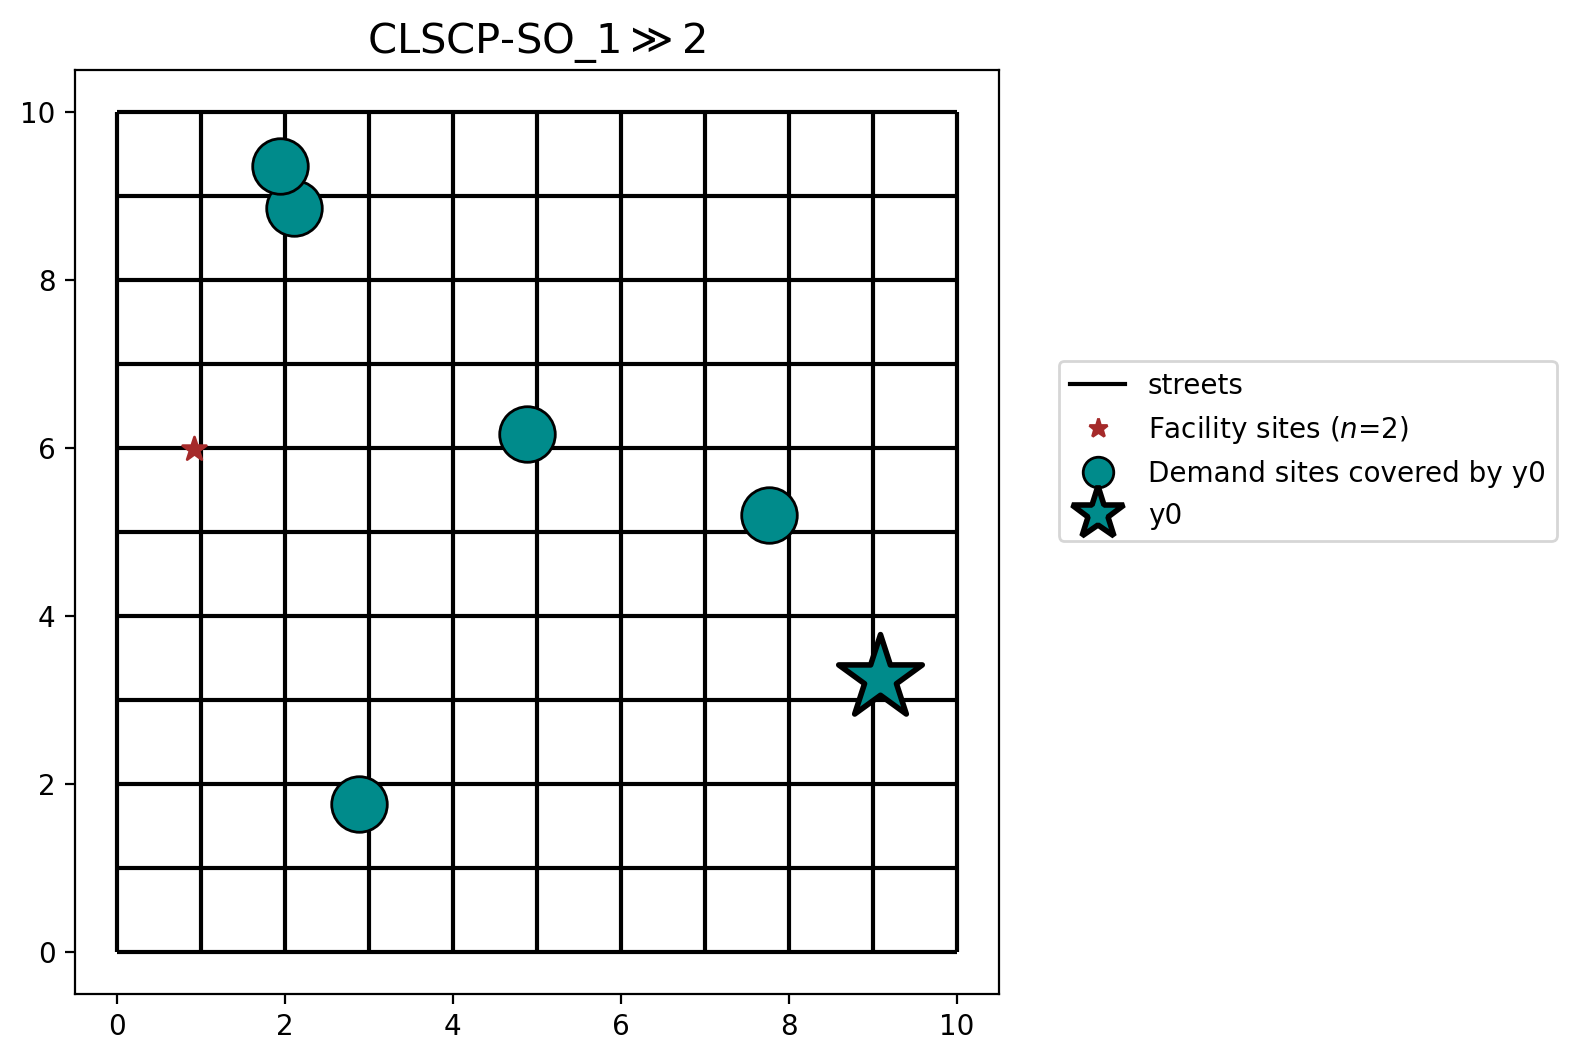

In [27]:
plot_results(
    clscpso_1, clscpso_1.problem.objective.value(), facility_points, clis=client_points
)

Facility $y_0$ is selected because it is the only feasible solution with a capacity of 15.

### Scenario 2

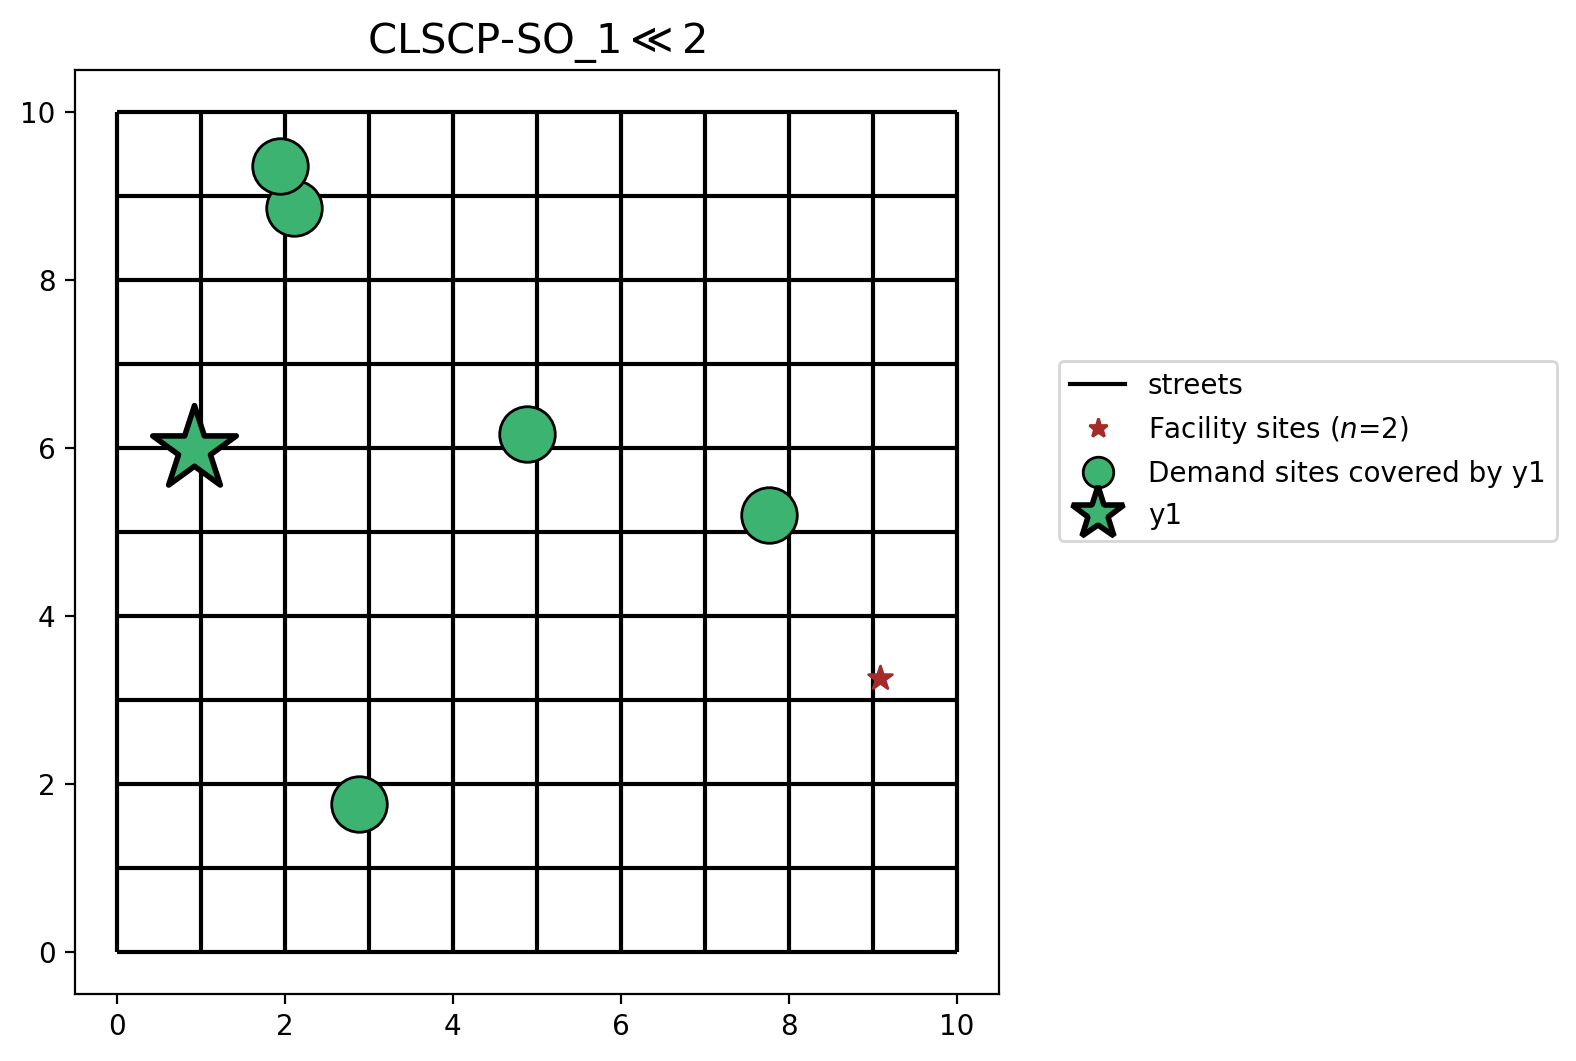

In [28]:
plot_results(
    clscpso_2, clscpso_2.problem.objective.value(), facility_points, clis=client_points
)

When swapping the capacities from scenario 1, Facility $y_1$ is selected because it is the only feasible solution with a capacity of 15.

### Scenario 3

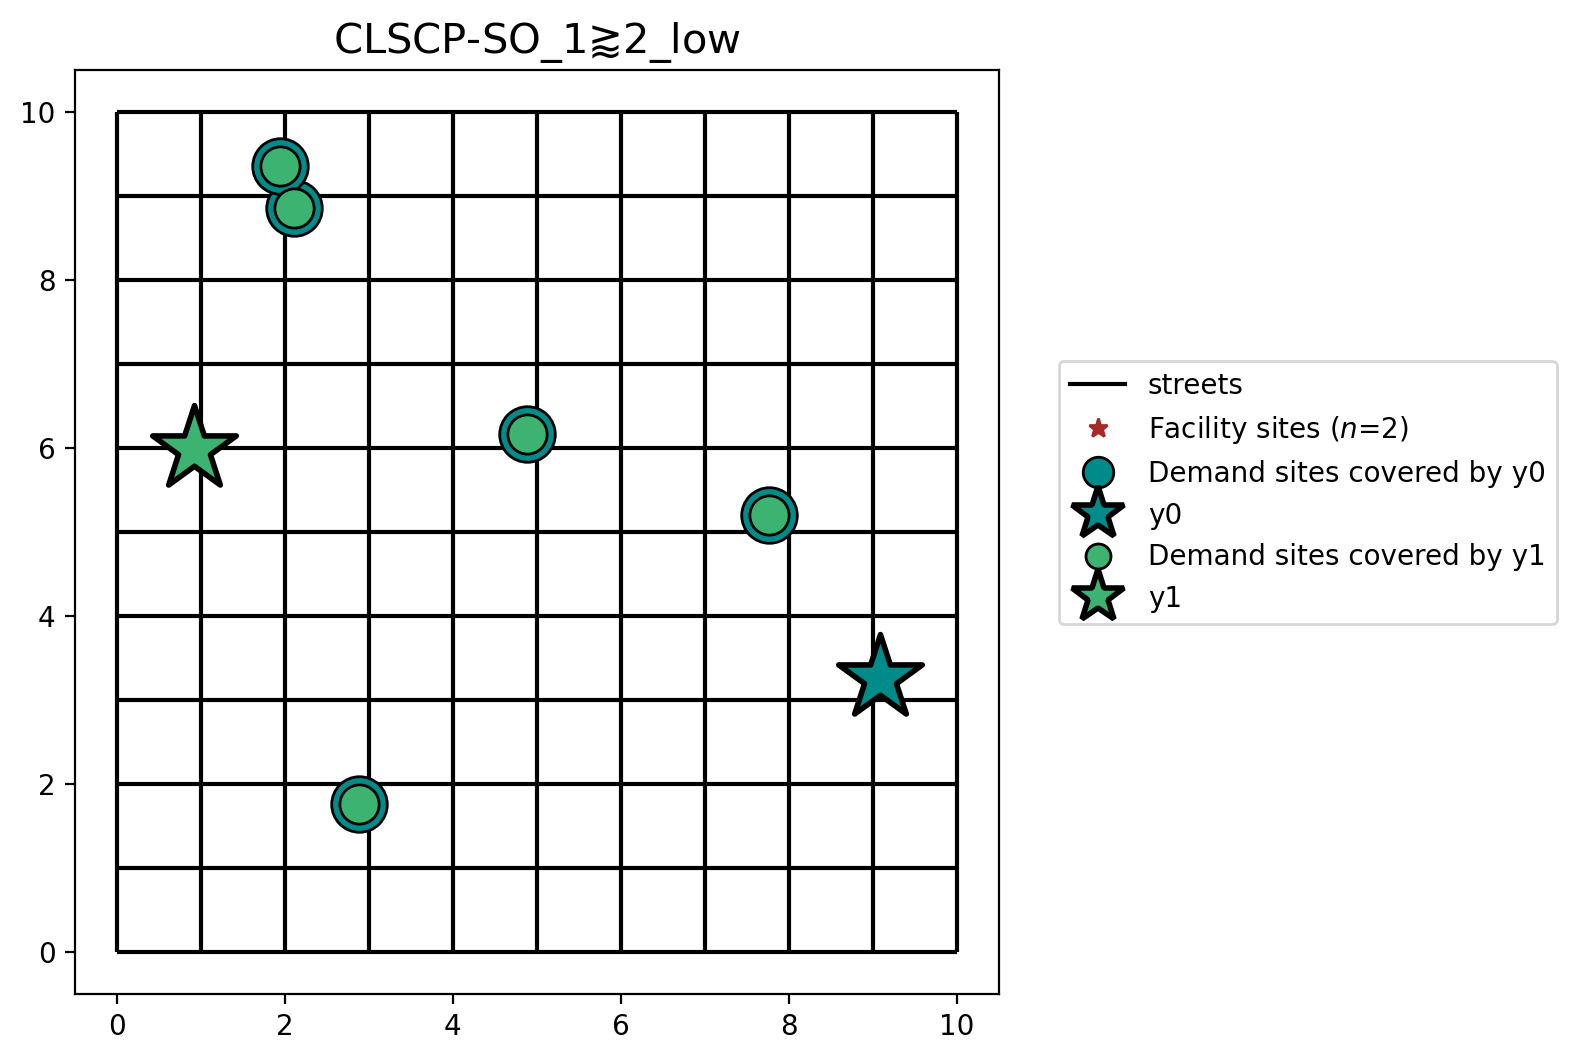

In [29]:
plot_results(
    clscpso_3, clscpso_3.problem.objective.value(), facility_points, clis=client_points
)

In scenario 3 neither facilities have the capacity to be the sole server of all client locations. However, they do have a combined capacity of 15. Therefore, both Facility $y_0$ and Facility $y_1$ are selected in the solution. Moreover, all client locations are within the 15 distance unit `SERVICE_RADIUS` from both facilities so they both can potentially serve all locations.

### Scenario 4

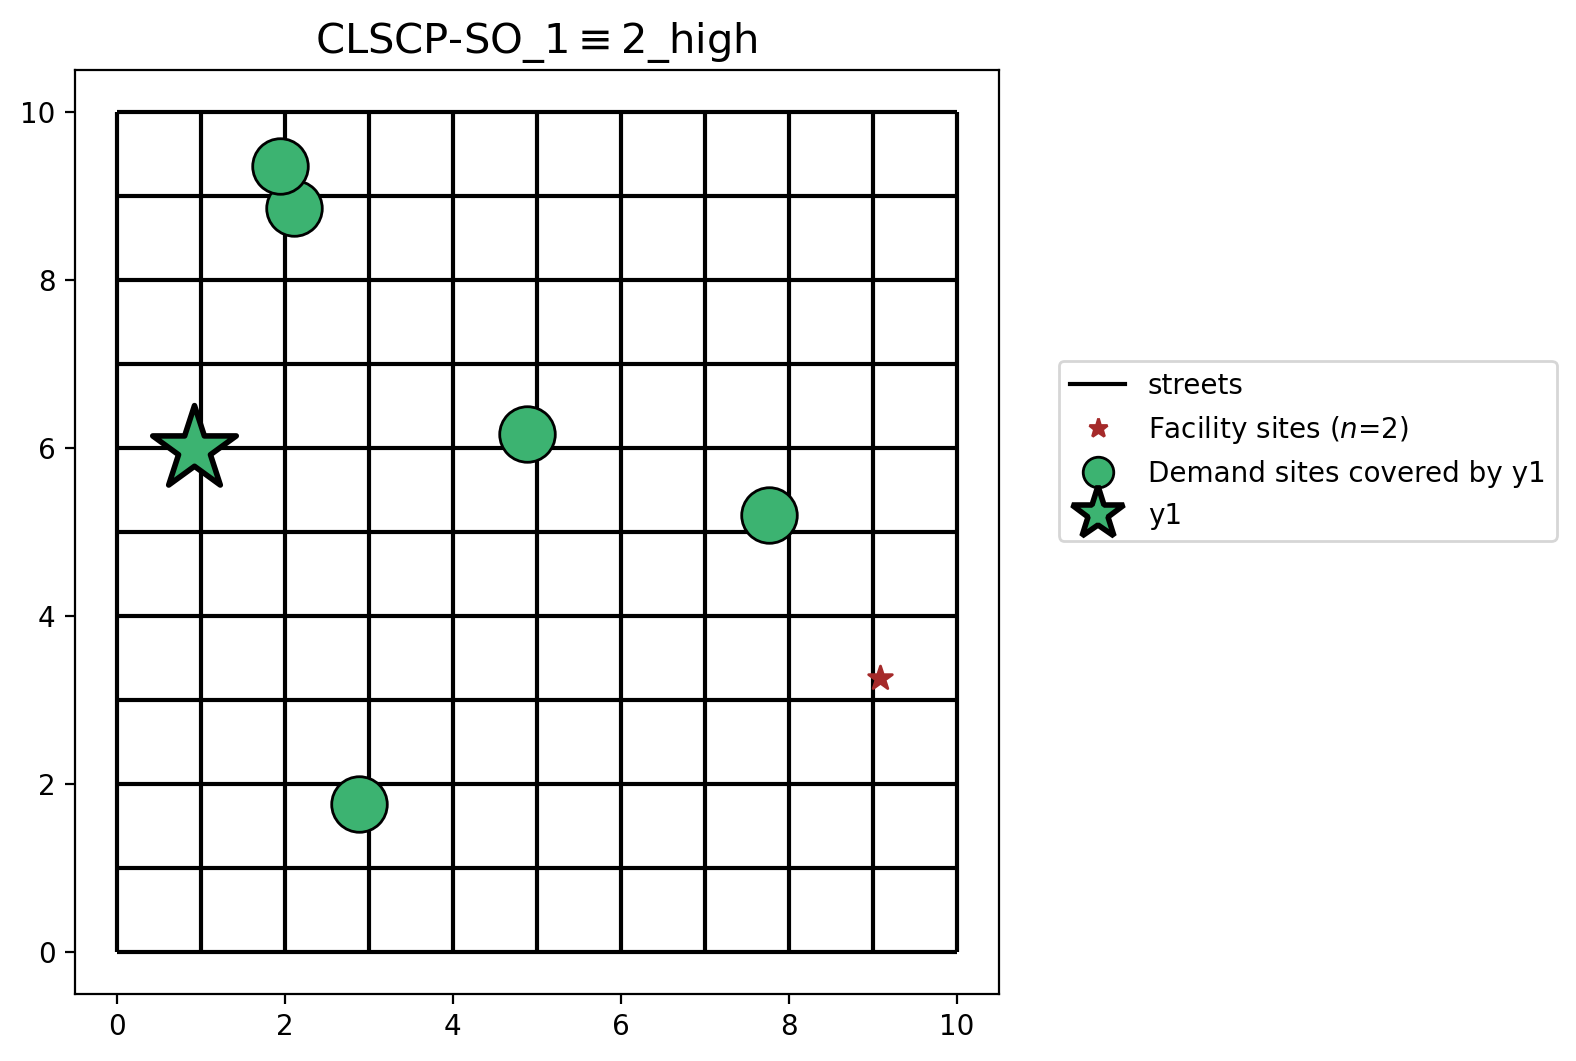

In [30]:
plot_results(
    clscpso_4, clscpso_4.problem.objective.value(), facility_points, clis=client_points
)

When setting facility capacities as equivalent, and high enough to serve the complete set of demand, only 1 facility is needed to satisfy the objective. The selection of Facility $y_1$ is arbitrary in this case and may differ according to the internel state when the solver begins the solution process.

### Scenario 5

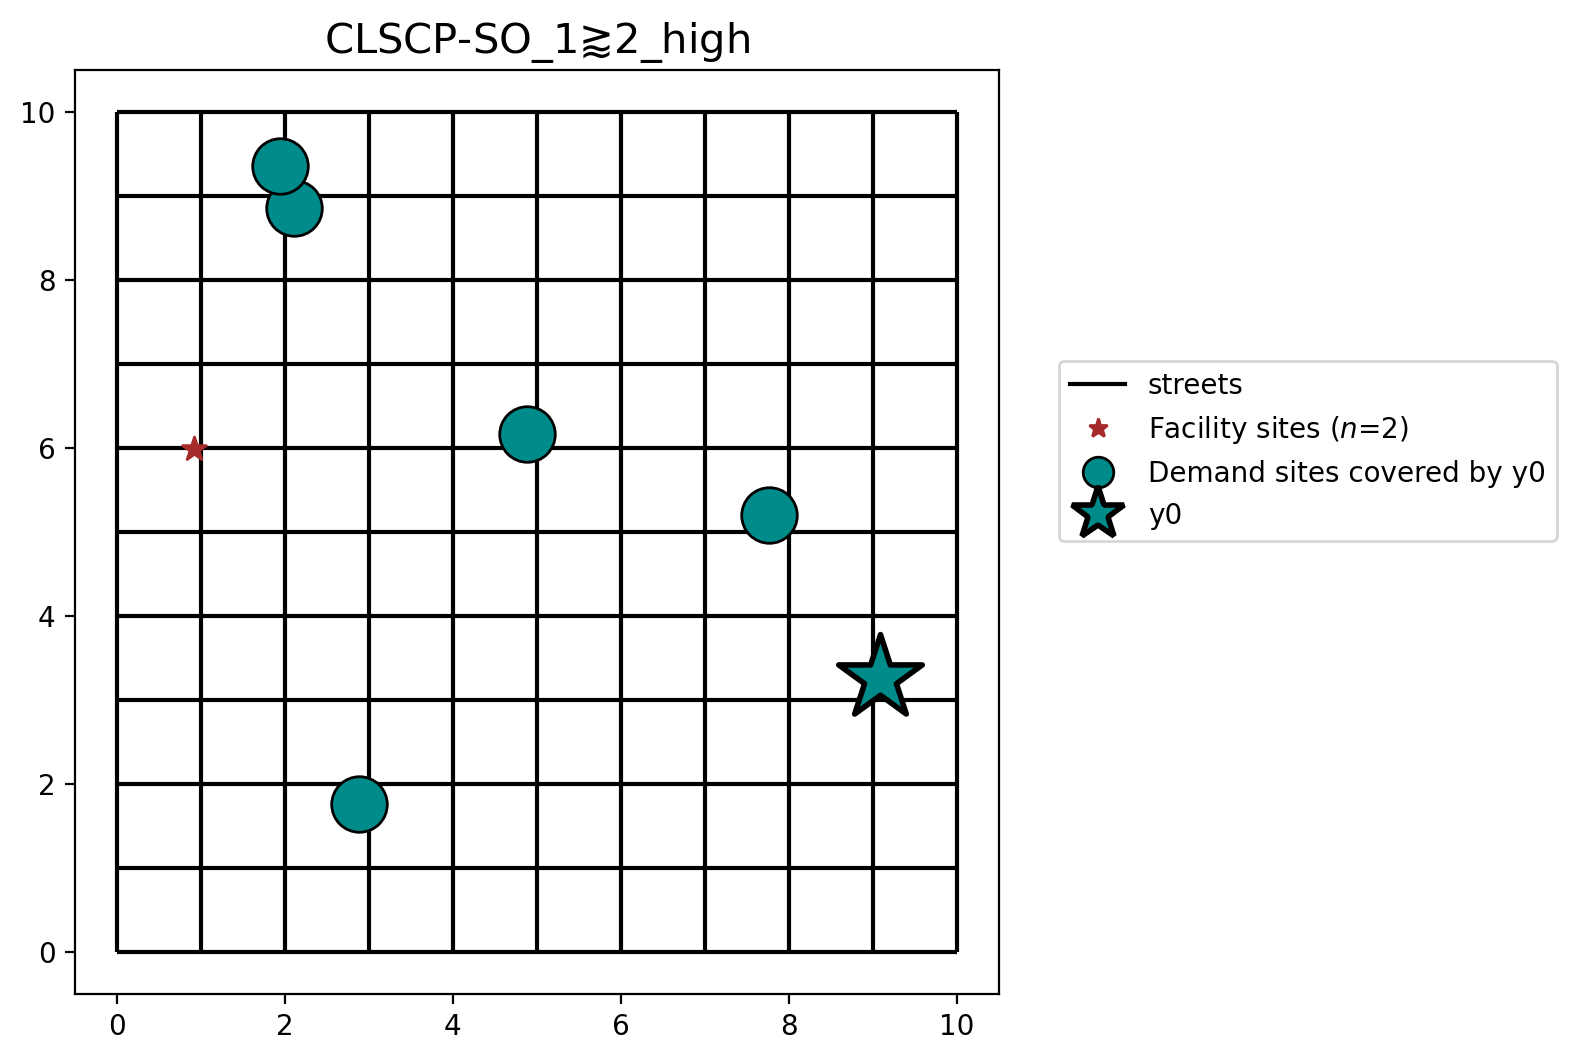

In [31]:
plot_results(
    clscpso_5, clscpso_5.problem.objective.value(), facility_points, clis=client_points
)

Scenario 5 shows that when both facilities are capable of serving all the demand, the facility with a higher capacity (Facility $y_0$ in this case) is selected.

### Scenario 6

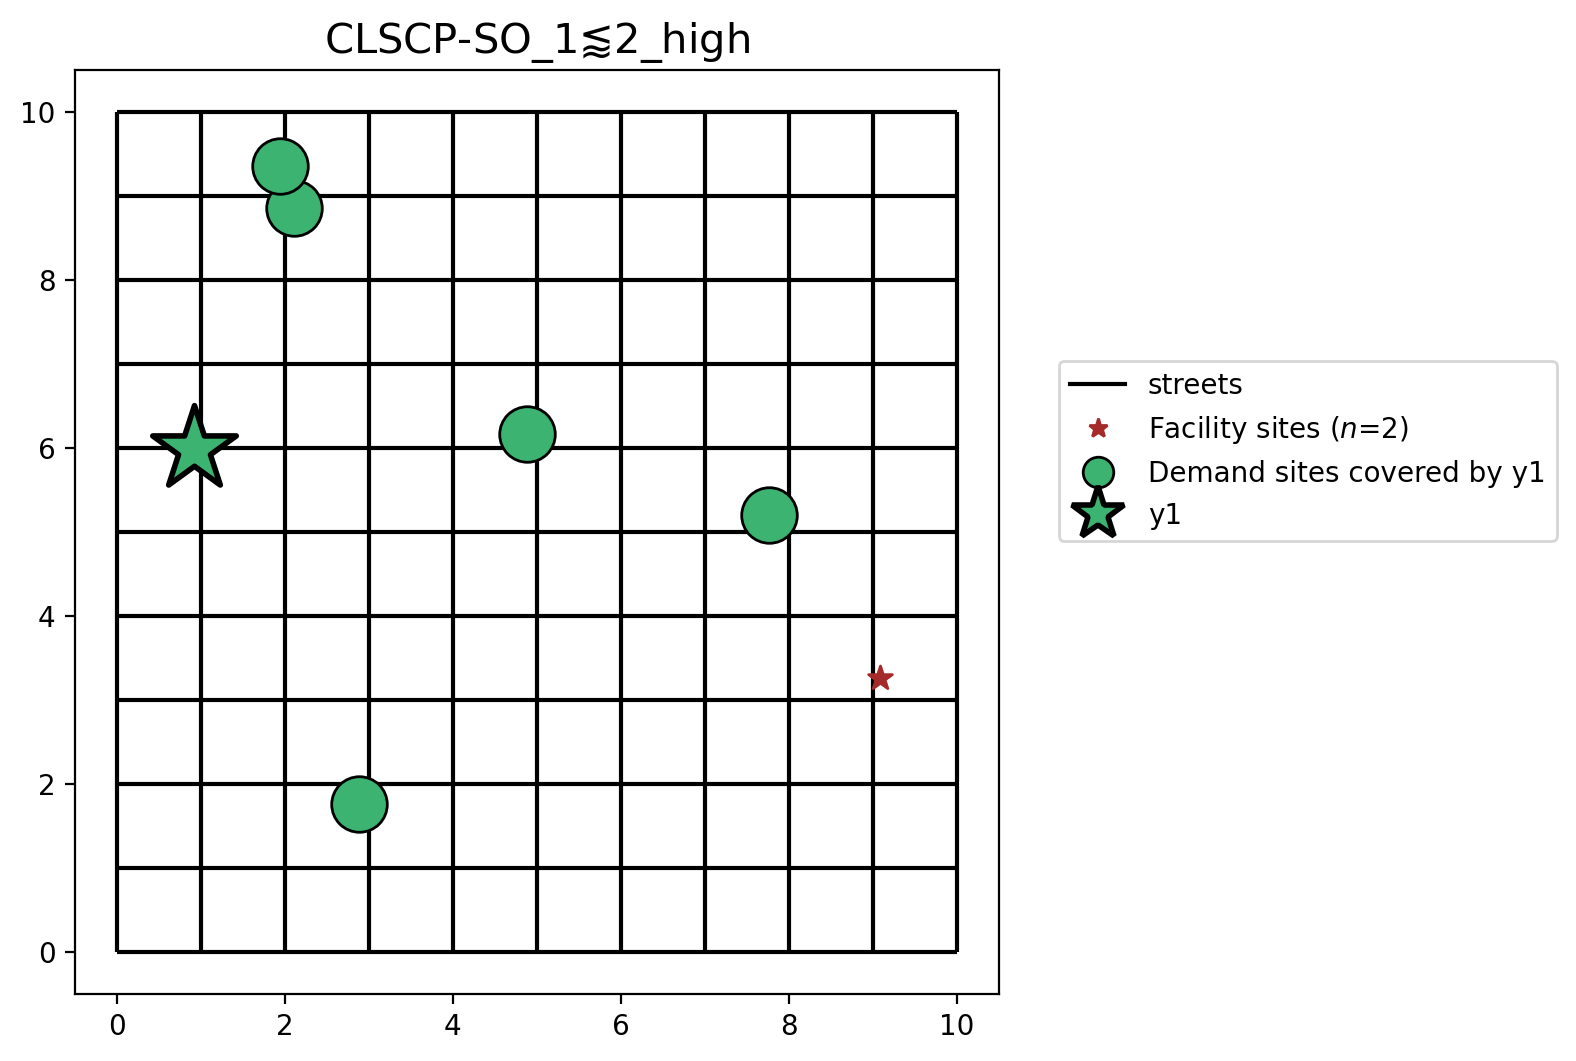

In [32]:
plot_results(
    clscpso_6, clscpso_6.problem.objective.value(), facility_points, clis=client_points
)

Scenario 6 demostrates the reverse situation from above in Scenario 5. Facility $y_1$ is selected over Facility $y_0$ because it has a larger capacity.


### A comparison of the solutions

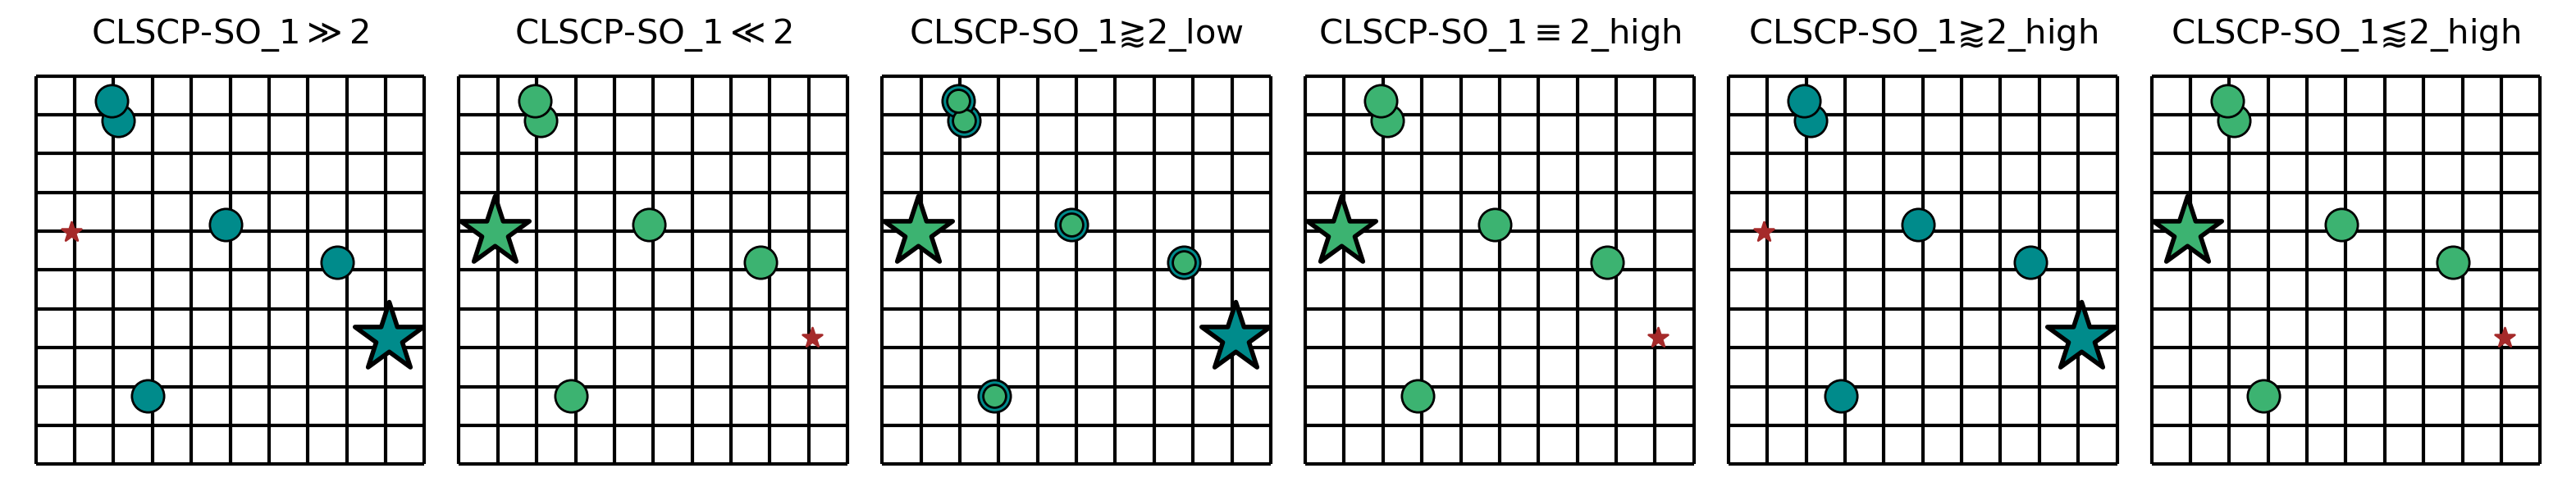

In [33]:
scenarios = [clscpso_1, clscpso_2, clscpso_3, clscpso_4, clscpso_5, clscpso_6]
fig, axarr = plt.subplots(1, len(scenarios), figsize=(20, 10))
fig.subplots_adjust(wspace=-0.01)
for i, m in enumerate(scenarios):
    plot_results(
        m, m.problem.objective.value(), facility_points, clis=client_points, ax=axarr[i]
    )

----------------------------------------

## 3. Comparing covering problems


Next we will set up, solve, and compare the CLSCP-SO to the standard LSCP with both more client locations and facilities. We will also stipulate that Facility $y_5$ must be part of the optimal solution in both models.

In [34]:
def snap_obs(_ntw, df, label):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # ignore deprecation warning - GH pysal/libpysal#468
        _ntw.snapobservations(df, label, attribute=True)
    df_snapped = spaghetti.element_as_gdf(_ntw, pp_name=label, snapped=True)
    df_snapped.drop(columns=["id", "comp_label"], inplace=True)
    return df_snapped

### Parameters and input data

In [35]:
# quantity demand points, supply points, & maximum service radius (in distance units)
CLIENT_COUNT, FACILITY_COUNT, SERVICE_RADIUS = 100, 10, 7

# generate  input data
_buff = geopandas.GeoSeries(streets["geometry"].buffer(0.5).unary_union)
_buff = geopandas.GeoDataFrame(geometry=_buff, crs=streets.crs)
client_points = simulated_geo_points(_buff, needed=CLIENT_COUNT, seed=CLIENT_SEED)
facility_points = simulated_geo_points(_buff, needed=FACILITY_COUNT, seed=FACILITY_SEED)
snap_obs(ntw, client_points, "clients")
snap_obs(ntw, facility_points, "facilities")

# calculate the OD cost matrix
orig, dest = ntw.pointpatterns["clients"], ntw.pointpatterns["facilities"]
cost_matrix = ntw.allneighbordistances(sourcepattern=orig, destpattern=dest)

### Stipulate that facility $y_5$ must be a member of the solution set

In [36]:
facility_points["predefined_loc"] = 0
facility_points.loc[[5], "predefined_loc"] = 1

### Generate synthetic demand

In [37]:
numpy.random.seed(222)
demand_quantity = numpy.random.randint(1, 5, CLIENT_COUNT)
total_demand = demand_quantity.sum()
client_points["demand"] = demand_quantity
print(f"Total demand: {total_demand}")
demand_quantity

Total demand: 238


array([3, 2, 4, 3, 3, 3, 1, 2, 3, 2, 4, 2, 4, 1, 1, 1, 1, 4, 3, 1, 1, 1,
       1, 2, 4, 4, 4, 1, 3, 4, 2, 2, 2, 1, 4, 2, 1, 3, 2, 2, 4, 4, 4, 4,
       1, 2, 2, 1, 2, 2, 2, 4, 1, 2, 2, 4, 2, 4, 1, 1, 1, 1, 1, 2, 2, 1,
       1, 1, 2, 4, 4, 4, 2, 2, 3, 3, 2, 3, 3, 1, 3, 1, 1, 3, 1, 2, 4, 1,
       4, 4, 3, 3, 1, 4, 1, 4, 4, 4, 3, 1])

### Generate synthetic capacity equal to at least 2x demand

In [38]:
cap_sum_search = True
numpy.random.seed(0)
while cap_sum_search:
    facility_capacity = numpy.random.randint(5, 100, FACILITY_COUNT)
    if facility_capacity.sum() >= demand_quantity.sum() * 2:
        cap_sum_search = False
facility_points["capacity"] = facility_capacity
print(f"Total capacity: {facility_points['capacity'].sum()}")
facility_points

Total capacity: 575


,geometry,predefined_loc,capacity
0,POINT (9.32146 3.15178),0,49
1,POINT (8.53352 -0.04134),0,52
2,POINT (0.68422 6.04557),0,69
3,POINT (5.32799 4.10688),0,72
4,POINT (3.18949 6.34771),0,72
5,POINT (4.31956 7.59470),1,14
6,POINT (5.19840 5.86744),0,88
7,POINT (6.59891 10.39247),0,26
8,POINT (8.51844 4.04521),0,41
9,POINT (9.13894 8.56135),0,92


### Solve & plot the CLSCP-SO

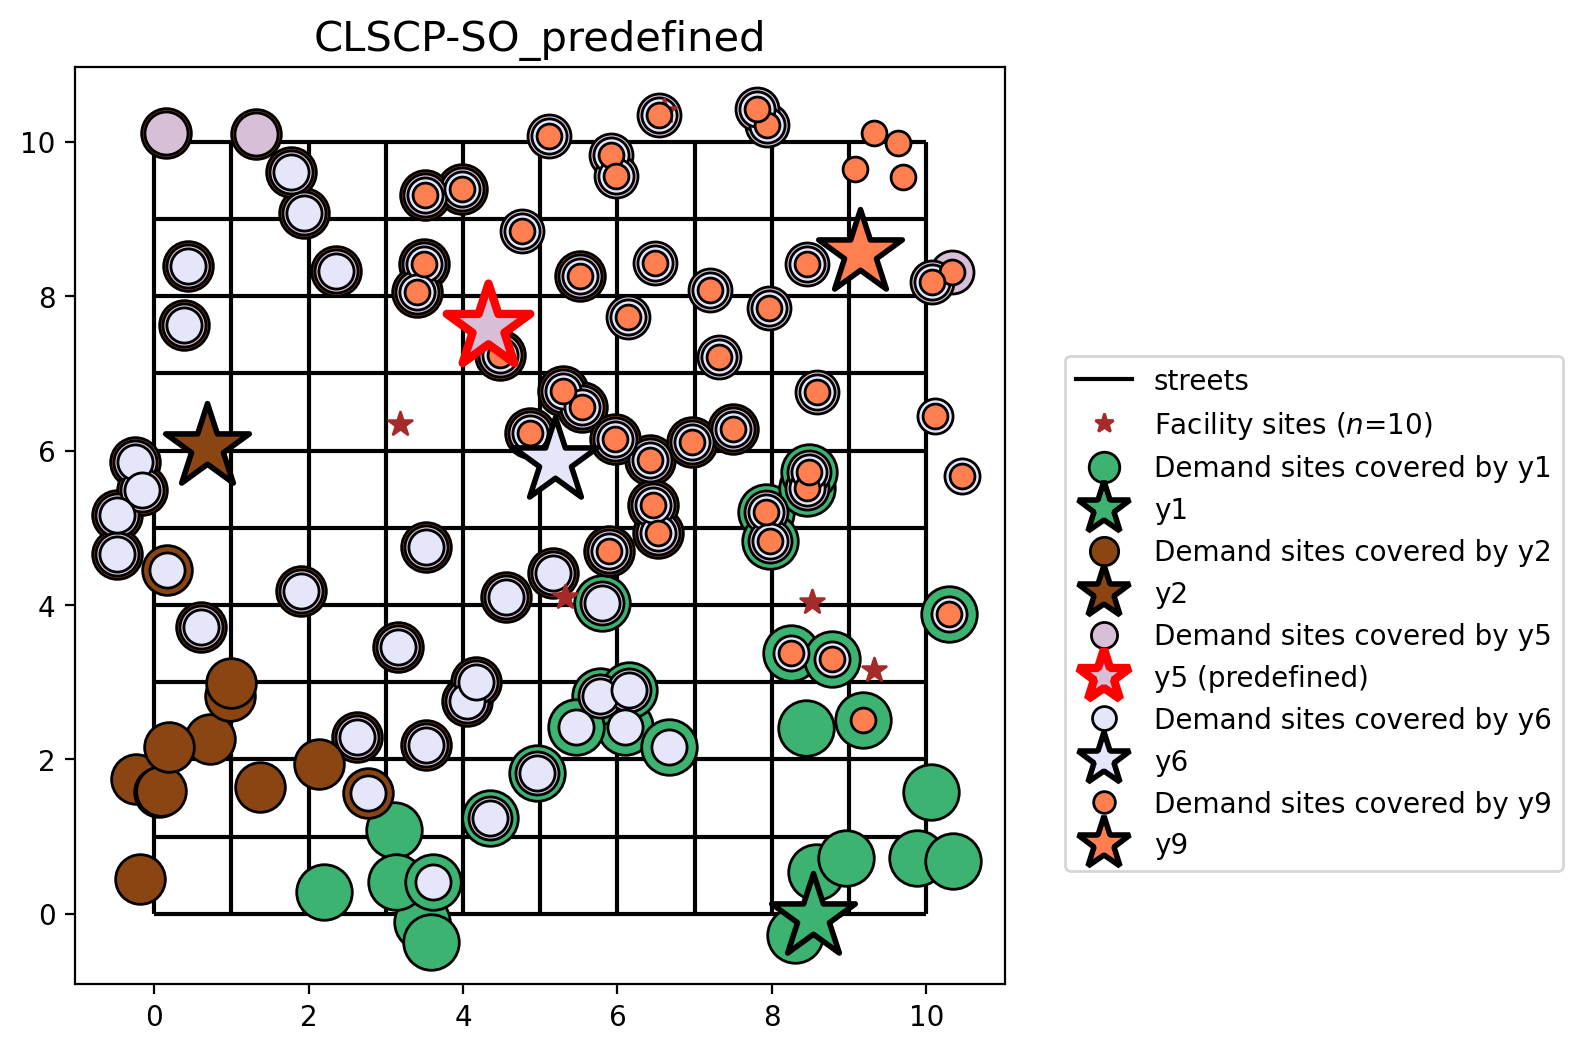

In [39]:
clscpso = LSCP.from_cost_matrix(
    cost_matrix,
    SERVICE_RADIUS,
    demand_quantity_arr=demand_quantity,
    facility_capacity_arr=facility_capacity,
    predefined_facilities_arr=facility_points["predefined_loc"],
    name="CLSCP-SO_predefined"
)
clscpso = clscpso.solve(solver)
facility_points["dv"] = clscpso.fac_vars
facility_points["dv"] = facility_points["dv"].map(lambda x: x.name.replace("_", ""))
plot_results(
    clscpso,
    clscpso.problem.objective.value(),
    facility_points,
    clis=client_points
)

### Solve & plot the standard LSCP

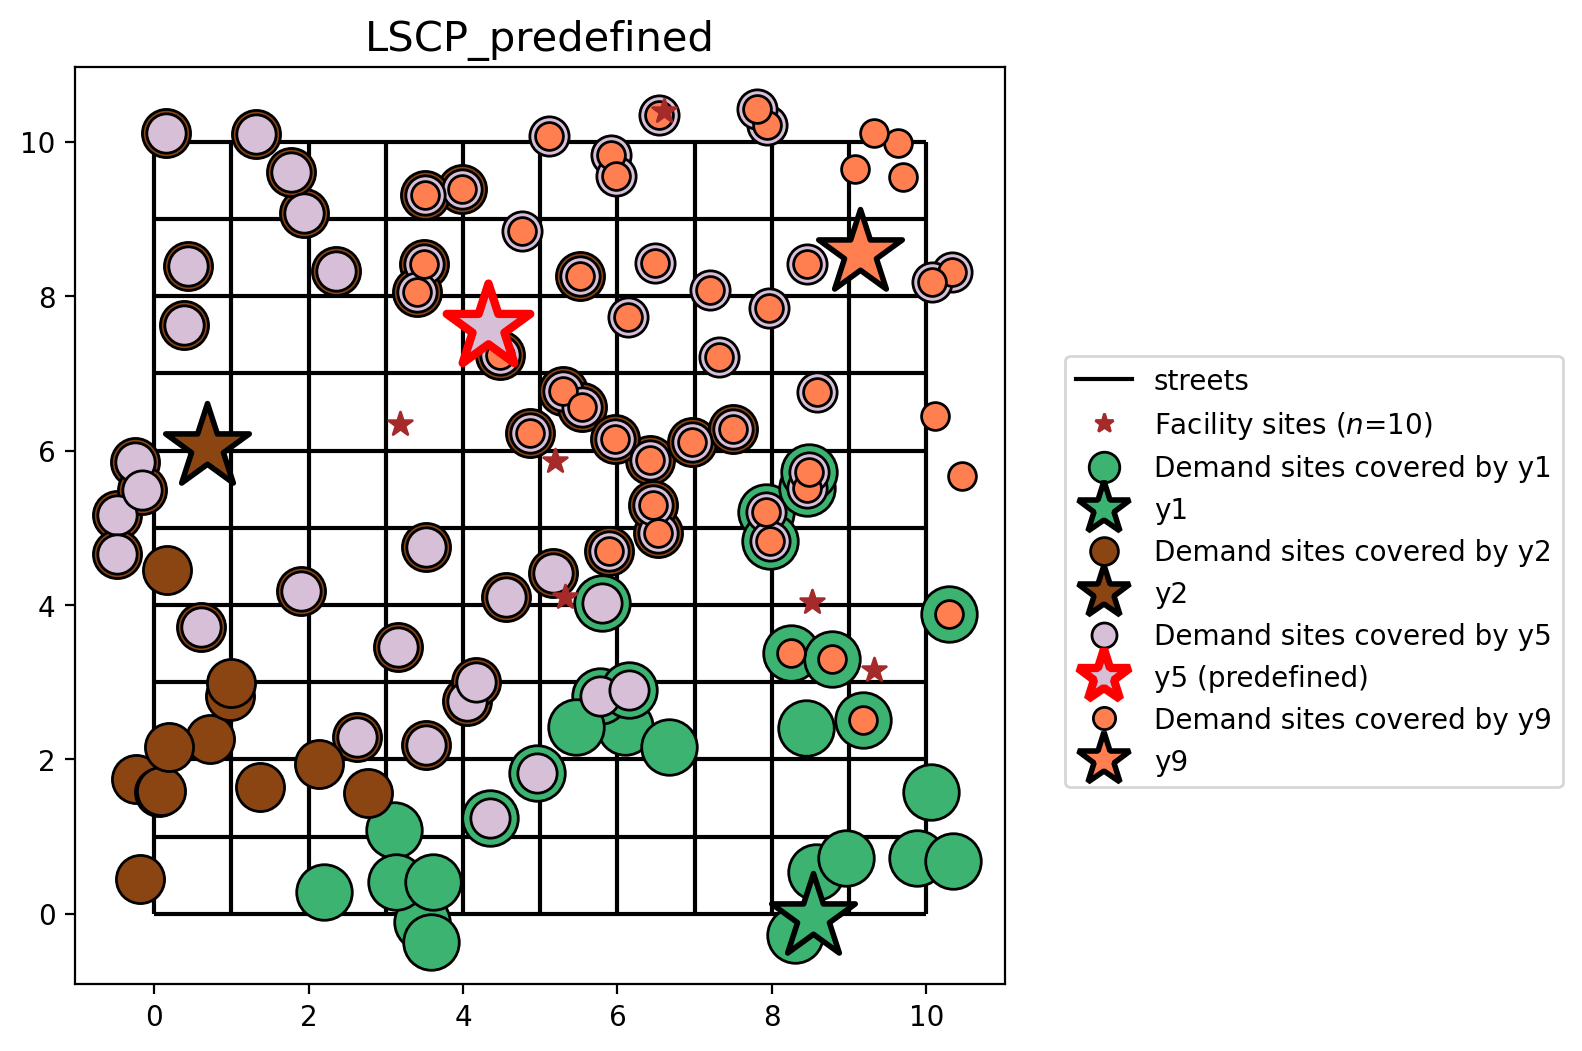

In [40]:
lscp = LSCP.from_cost_matrix(
    cost_matrix,
    SERVICE_RADIUS,
    predefined_facilities_arr=facility_points["predefined_loc"],
    name="LSCP_predefined"
)
lscp = lscp.solve(solver)
plot_results(
    lscp,
    lscp.problem.objective.value(),
    facility_points,
    clis=client_points
)

### Compare the results

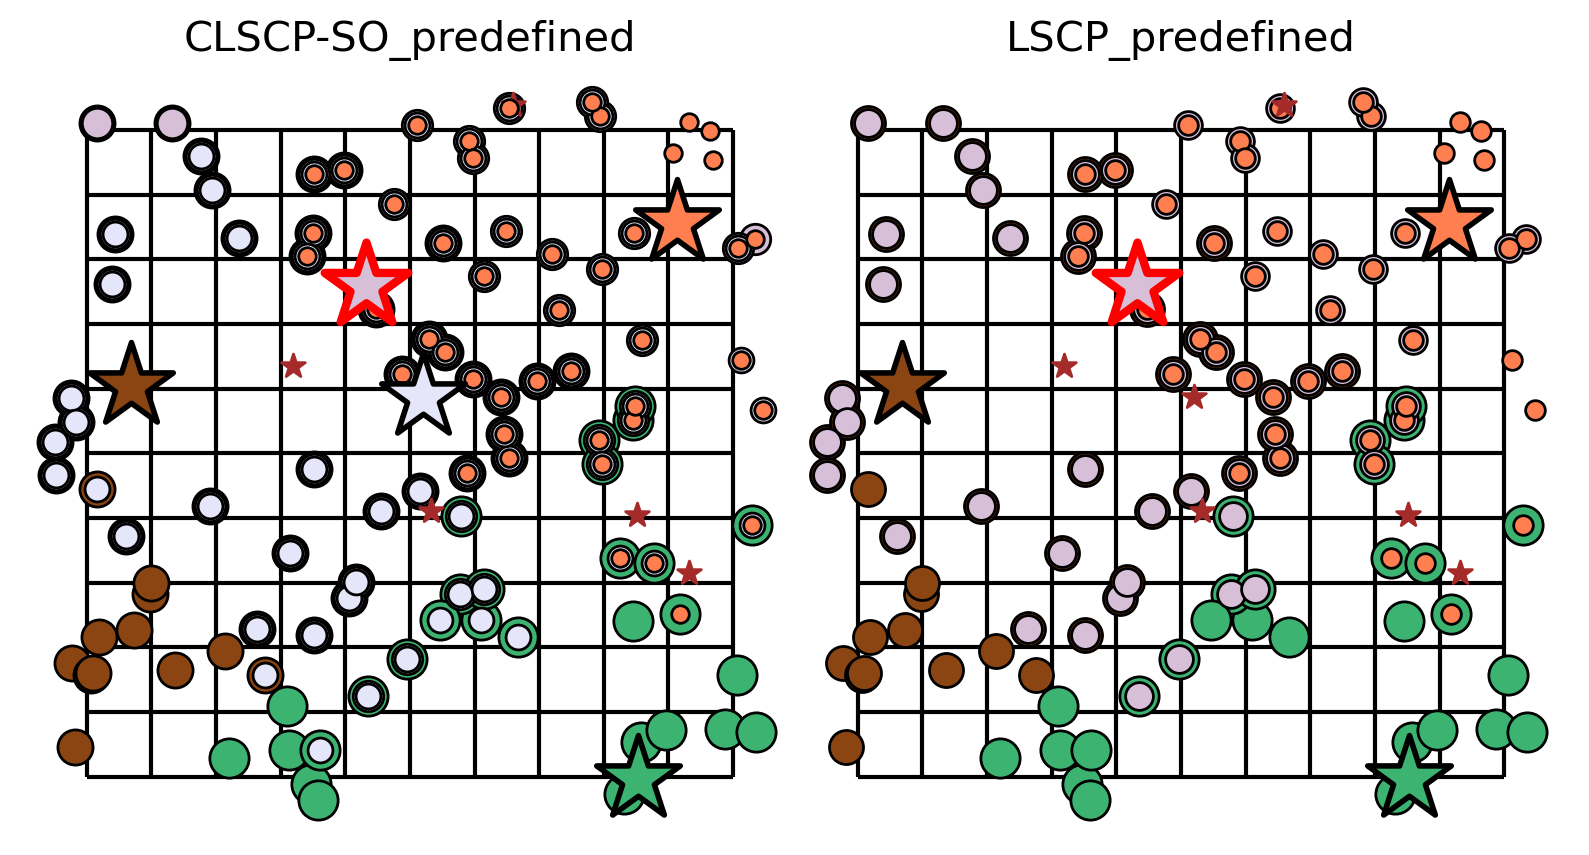

In [41]:
models = [clscpso, lscp]
fig, axarr = plt.subplots(1, len(models), figsize=(10, 10))
fig.subplots_adjust(wspace=-0.01, hspace=-0.01)
for i, m in enumerate(models):
    plot_results(
        m, m.problem.objective.value(), facility_points, clis=client_points, ax=axarr[i]
    )

Here we can see the solutions to the CLSCP-SO and LSCP are very similar. Facilities $y_1$ (green), $y_2$ (brown), $y_5$ (darker violet), and $y_9$ (orange) are present in both solutions, with $y_5$ being pre-defined in both. In fact, the only difference between the two models is the inclusion of Facility $y_6$ (lighter lilac) in the CLSCP-SO solution. This difference is due to taking client demand into consideration along with facility capacity.

----------------------

## References

- [Church, R. L., & Murray, A. T. (2018). Location covering models: History, Applications and Advancements (1st edition 2018). Springer](https://www.springer.com/gb/book/9783319998459)
- [Current, J. R., & Storbeck, J. E. (1988). Capacitated Covering Models. Environment and Planning B: Planning and Design, 15(2):153–163, 1988. doi:10.1068/b150153.](https://journals.sagepub.com/doi/abs/10.1068/b150153)